### 导入autoload扩展

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from solve import Solver
help(Solver)

Help on class Solver in module solve:

class Solver(builtins.object)
 |  Solver(model: full_connect_network.FullConnectNet, data: Dict, **kwargs) -> None
 |  
 |  A Solver encapsulates all the logic necessary for training classification
 |  models. The Solver performs stochastic gradient descent using different
 |  update rules.
 |  The solver accepts both training and validation data and labels so it can
 |  periodically check classification accuracy on both training and validation
 |  data to watch out for overfitting.
 |  To train a model, you will first construct a Solver instance, passing the
 |  model, dataset, and various options (learning rate, batch size, etc) to the
 |  constructor. You will then call the train() method to run the optimization
 |  procedure and train the model.
 |  After the train() method returns, model.params will contain the parameters
 |  that performed best on the validation set over the course of training.
 |  In addition, the instance variable solver.l

### 下载并载入[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)数据集

In [3]:
from utils import *
from full_connect_network import FullConnectNet
from solve import Solver

data = download_minist()
data['X_train'] = data['X_train']
data['y_train'] = data['y_train']

def train_with_params(
        hidden_dims, 
        types, 
        reg, 
        update_rule,
        optim_config,
        lr_decay,
        batch_size,
        iters,
        epochs
    ):
    
    three_layer_model = FullConnectNet(
        hidden_dims=hidden_dims, 
        types=types, 
        reg=reg, 
    )

    three_layer_net = Solver(
        model=three_layer_model, 
        data=data,
        update_rule=update_rule,
        optim_config=optim_config,
        lr_decay=lr_decay,
        batch_size=batch_size,
        print_iter=500,
        iters=iters,
        num_epochs=epochs
    )

    three_layer_net.train() 

    plot_stats_single(three_layer_net)    
    return three_layer_net

(Time   0.00 s; Iteration     1 / 60000) loss 2.304774
[Epoch  0 / 30] train accuracy: 0.111167; val accuracy: 0.113900
(Time   2.08 s; Iteration   501 / 60000) loss 0.723685
(Time   3.84 s; Iteration  1001 / 60000) loss 0.621492
(Time   5.65 s; Iteration  1501 / 60000) loss 0.363826
[Epoch  1 / 30] train accuracy: 0.851733; val accuracy: 0.838200
(Time   7.87 s; Iteration  2001 / 60000) loss 0.432966
(Time   9.83 s; Iteration  2501 / 60000) loss 0.213456
(Time  11.99 s; Iteration  3001 / 60000) loss 0.340165
(Time  14.11 s; Iteration  3501 / 60000) loss 0.285024
[Epoch  2 / 30] train accuracy: 0.878183; val accuracy: 0.858600
(Time  16.36 s; Iteration  4001 / 60000) loss 0.325864
(Time  18.06 s; Iteration  4501 / 60000) loss 0.179470
(Time  19.67 s; Iteration  5001 / 60000) loss 0.170526
(Time  21.56 s; Iteration  5501 / 60000) loss 0.216958
[Epoch  3 / 30] train accuracy: 0.888883; val accuracy: 0.865400
(Time  23.73 s; Iteration  6001 / 60000) loss 0.358683
(Time  25.61 s; Iteration

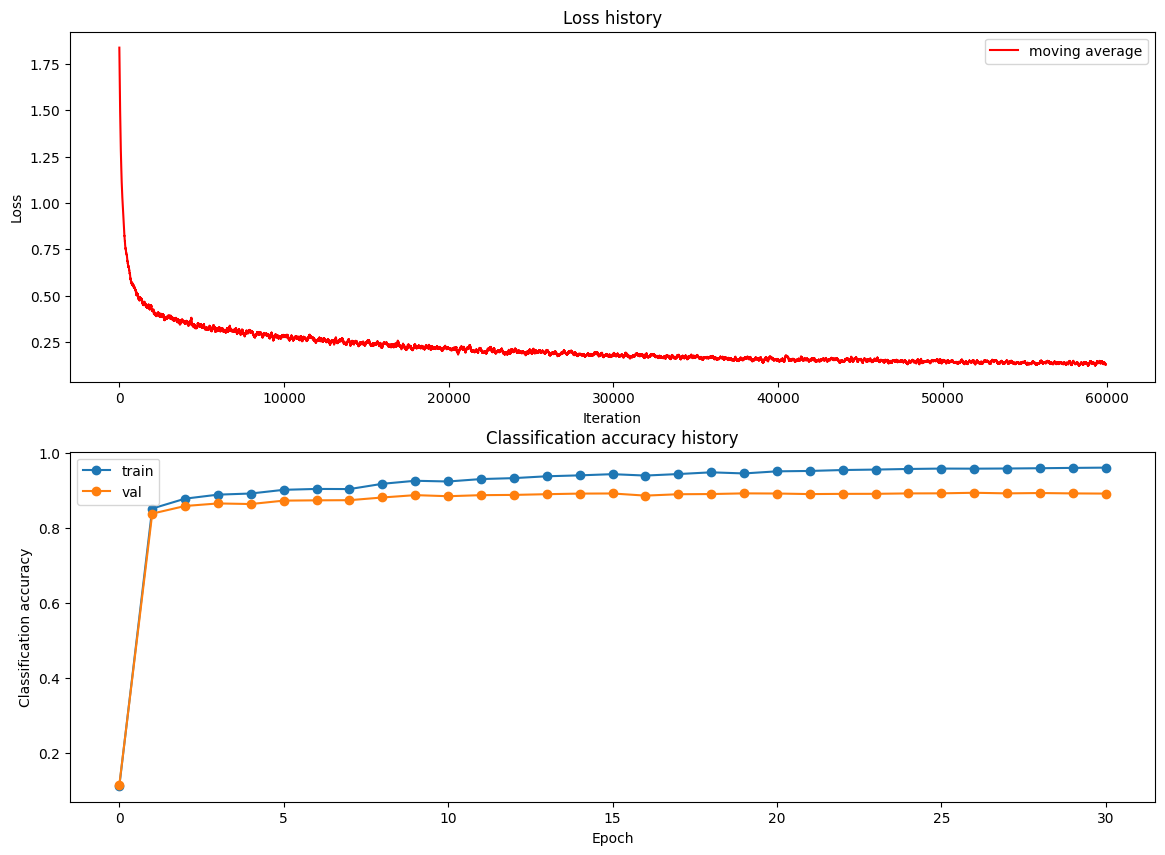

Model has been saved in model\fcnn


In [9]:
np.random.seed(419)

hidden_dims = [128, 64]
activation = ['relu', 'tanh']
reg = 1e-3

update_rule = 'sgd'
optim_config = {
    'learning_rate': 5e-3
}
lr_decay=0.9
batch_size=64
print_iter=500
iters=60000
epochs=30

nn = train_with_params(
        hidden_dims=hidden_dims, 
        types=activation, 
        reg=reg, 
        update_rule=update_rule,
        optim_config=optim_config,
        lr_decay=lr_decay,
        batch_size=batch_size,
        iters=iters,
        epochs=epochs
    )

model_path = 'fcnn'
nn.save(model_path)

```python
# sgd_momentum
{
    hidden_dims = [128, 64, 32]
    activation = ['relu']
    reg = 1e-3
    loss = 'ce'
    three_layer_model = FullConnectNet(
        hidden_dims=hidden_dims, 
        types=activation, 
        reg=reg, 
        loss=loss
    )
    three_layer_net = Solver(
        model=three_layer_model, 
        data=data,
        update_rule='sgd_momentum',
        optim_config = {
            'learning_rate': 1e-2
        },
        lr_decay=0.9 / 0.8,
        batch_size=64,
        print_iter=100
    )
}
# adam
{
    hidden_dims = [64, 32]
    activation = ['relu']
    reg = 1e-3
    loss = 'ce'

    update_rule = 'adam'
    optim_config = {
        'learning_rate': 1e-4
    }
    lr_decay=0.8
    batch_size=128
    print_iter=500
    iters=20000
}
# sgd
{
    hidden_dims = [128, 64]
    activation = ['relu']
    reg = 1e-3
    loss = 'ce'

    update_rule = 'sgd'
    optim_config = {
        'learning_rate': 5e-3
    }
    lr_decay=0.9
    batch_size=64
    print_iter=500
    iters=2000
}

```

In [ ]:
y = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

x = np.argmax(y, axis=1)
print(x)
print(y[np.arange(2), x])

[2 2]
[3 6]
